In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import missingno as msno
import datetime

import warnings 

warnings.filterwarnings('ignore')

In [2]:
df_10_11 = pd.read_csv('data/year_2010_2011.csv',encoding='latin1')

In [3]:
df_10_11.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


In [4]:
df_10_11.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541910 entries, 0 to 541909
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   Invoice      541910 non-null  object 
 1   StockCode    541910 non-null  object 
 2   Description  540456 non-null  object 
 3   Quantity     541910 non-null  int64  
 4   InvoiceDate  541910 non-null  object 
 5   Price        541910 non-null  float64
 6   Customer ID  406830 non-null  float64
 7   Country      541910 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


In [5]:
df_10_11.describe()

,Quantity,Price,Customer ID
count,541910.000000,541910.000000,406830.000000
mean,9.552234,4.611138,15287.684160
std,218.080957,96.759765,1713.603074
min,-80995.000000,-11062.060000,12346.000000
25%,1.000000,1.250000,13953.000000
50%,3.000000,2.080000,15152.000000
75%,10.000000,4.130000,16791.000000
max,80995.000000,38970.000000,18287.000000


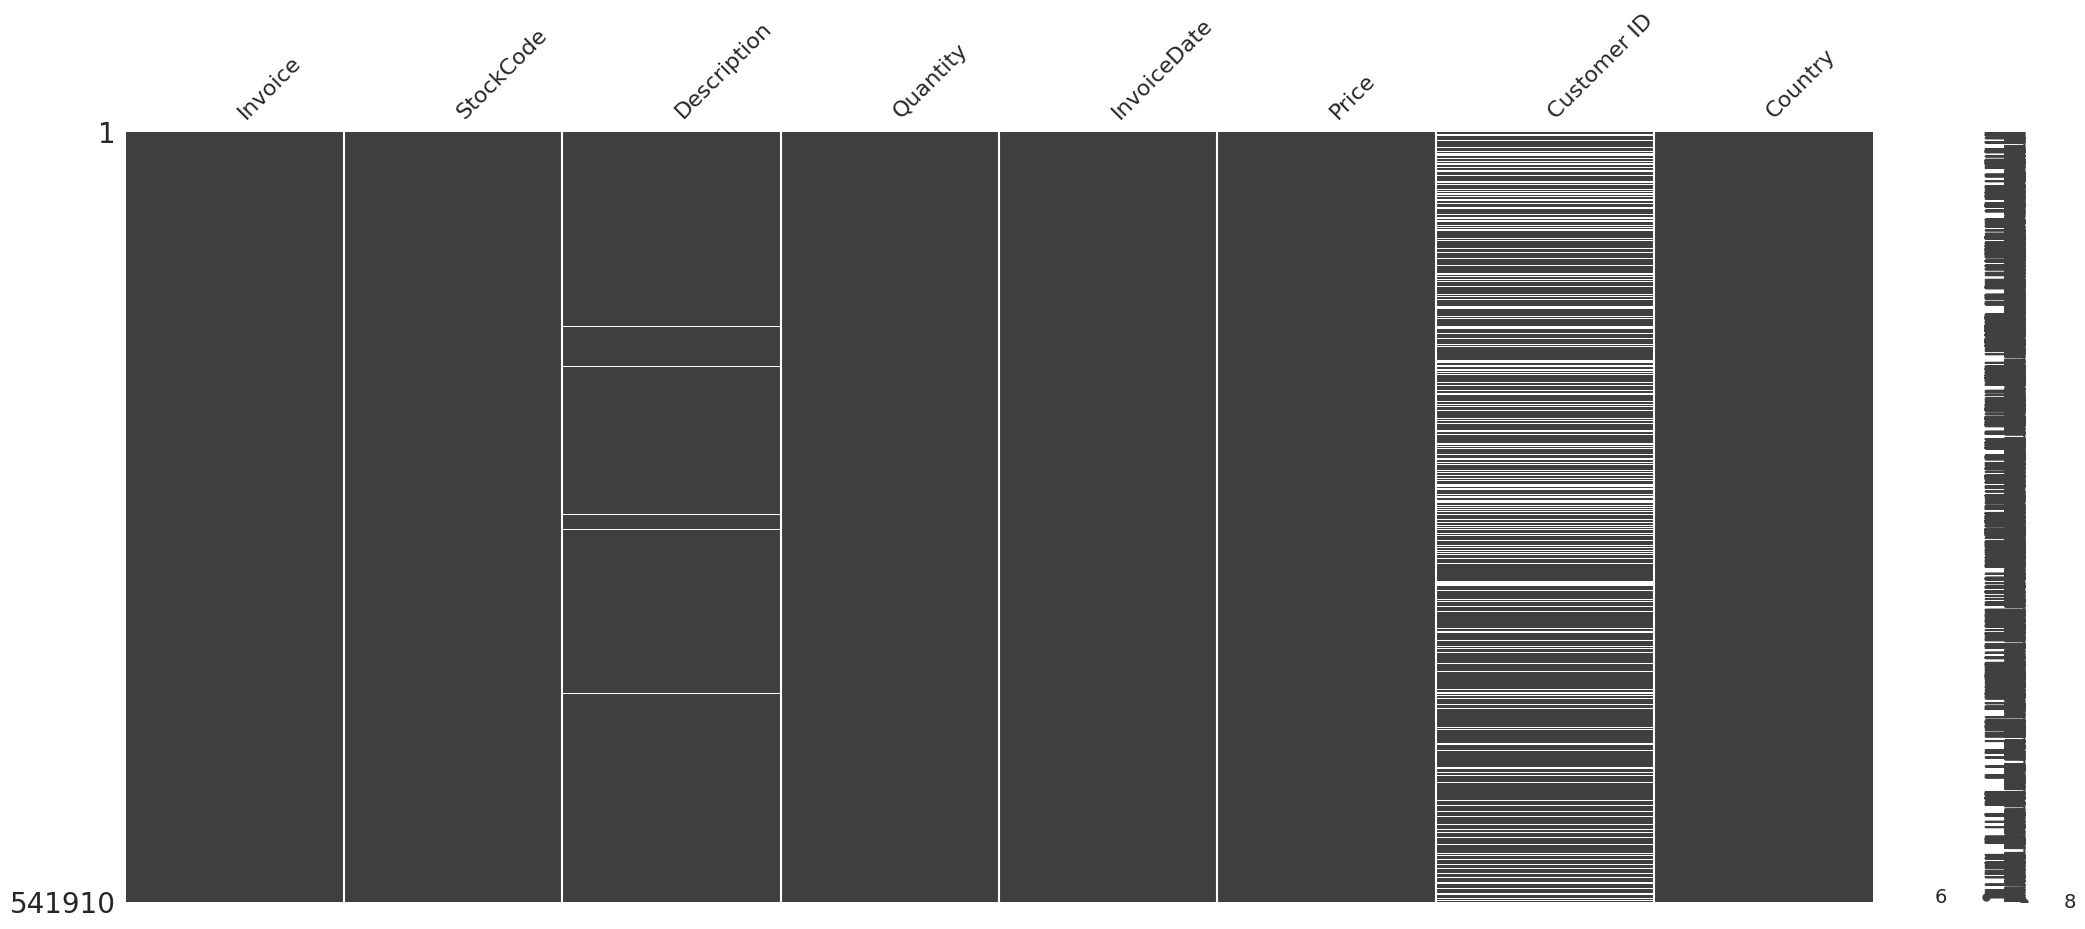

In [6]:
msno.matrix(df_10_11)
plt.show()

In [7]:
print(df_10_11.isnull().sum())

Invoice             0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
Price               0
Customer ID    135080
Country             0
dtype: int64


In [8]:
# get unique values of CustomerID
df_10_11['Customer ID'].nunique()

4372

In [9]:
df_10_11.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541910 entries, 0 to 541909
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   Invoice      541910 non-null  object 
 1   StockCode    541910 non-null  object 
 2   Description  540456 non-null  object 
 3   Quantity     541910 non-null  int64  
 4   InvoiceDate  541910 non-null  object 
 5   Price        541910 non-null  float64
 6   Customer ID  406830 non-null  float64
 7   Country      541910 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


In [10]:
print(df_10_11.columns)

Index(['Invoice', 'StockCode', 'Description', 'Quantity', 'InvoiceDate',
       'Price', 'Customer ID', 'Country'],
      dtype='object')


In [11]:
# Tarih sütununun datetime formatına dönüştürülmesi
df_10_11['InvoiceDate'] = pd.to_datetime(df_10_11['InvoiceDate'])

# Bugünün tarihi (veri setine göre uyarlayın)
today_date = datetime.datetime(2011, 12, 10)

In [12]:
# RFM metriklerinin hesaplanması
rfm = df_10_11.groupby('Customer ID').agg({
    'InvoiceDate': lambda x: (today_date - x.max()).days,
    'Invoice': 'count',
    'Price': lambda x: (x * df_10_11.loc[x.index, 'Quantity']).sum()
})

# RFM metriklerinin yeniden adlandırılması
rfm.columns = ['Recency', 'Frequency', 'Monetary']

# RFM skorlarının hesaplanması
rfm['RecencyScore'] = pd.qcut(rfm['Recency'], 4, ['4', '3', '2', '1'])
rfm['FrequencyScore'] = pd.qcut(rfm['Frequency'].rank(method='first'), 4, ['1', '2', '3', '4'])
rfm['MonetaryScore'] = pd.qcut(rfm['Monetary'], 4, ['1', '2', '3', '4'])

# RFM skorlarının birleştirilmesi
rfm['RFMScore'] = rfm['RecencyScore'].astype(str) + rfm['FrequencyScore'].astype(str) + rfm['MonetaryScore'].astype(str)


In [13]:
# Segmentlerin belirlenmesi
def segment_customer(df):
    if df['RFMScore'] == '444':
        return 'Best Customers'
    elif df['RFMScore'] == '111':
        return 'Lost Customers'
    elif df['RecencyScore'] == '4':
        return 'Loyal Customers'
    else:
        return 'Others'

rfm['Segment'] = rfm.apply(segment_customer, axis=1)

# Sonuçların gözden geçirilmesi
rfm.head()


,Recency,Frequency,Monetary,RecencyScore,FrequencyScore,MonetaryScore,RFMScore,Segment
Customer ID,,,,,,,,
12346.0,325,2,0.00,1,1,1,111,Lost Customers
12347.0,2,182,4310.00,4,4,4,444,Best Customers
12348.0,75,31,1797.24,2,2,4,224,Others
12349.0,18,73,1757.55,3,3,4,334,Others
12350.0,310,17,334.40,1,1,2,112,Others


**Segment Açıklamaları**
* Best Customers: En iyi müşteriler, sık alışveriş yapan ve yüksek harcama yapan müşterilerdir.
* Loyal Customers: Sadık müşteriler, düzenli olarak alışveriş yapan ve son zamanlarda alışveriş yapmış müşterilerdir.
* Lost Customers: Kayıp müşteriler, uzun süredir alışveriş yapmamış ve düşük harcama yapmış müşterilerdir.
* Others: Diğer müşteriler, yukarıdaki segmentlere girmeyen müşterilerdir.

In [14]:
rfm['Segment'].value_counts()

Segment
Others             2891
Loyal Customers     637
Best Customers      459
Lost Customers      385
Name: count, dtype: int64

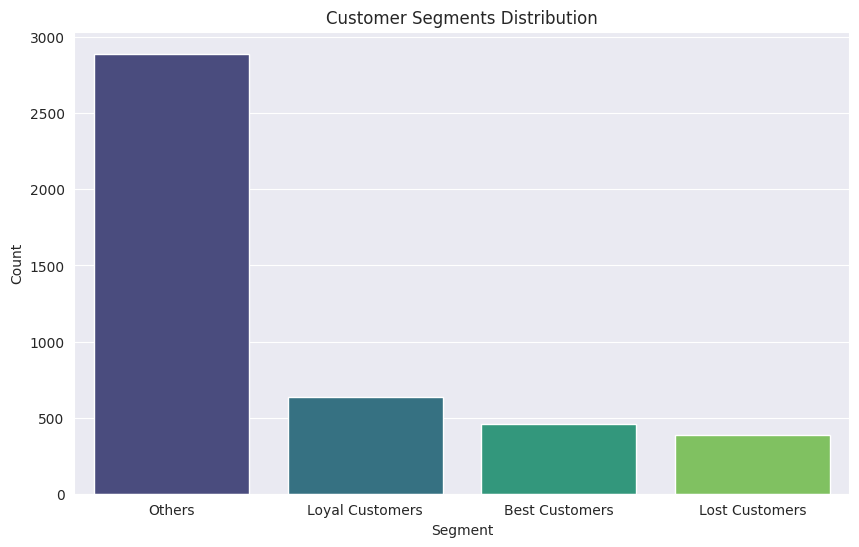

In [15]:
# RFM sonuçlarını içeren veri çerçevesi
segment_counts = rfm['Segment'].value_counts().to_dict()
# Veri çerçevesine dönüştürme
segment_df = pd.DataFrame(list(segment_counts.items()), columns=['Segment', 'Count'])

# Çubuk grafik
plt.figure(figsize=(10, 6))
sns.barplot(x='Segment', y='Count', data=segment_df, palette='viridis')
plt.title('Customer Segments Distribution')
plt.xlabel('Segment')
plt.ylabel('Count')
plt.show()
